**1. Importing Libraries**
- Imports necessary libraries for deep learning (PyTorch, Transformers), image processing (PIL), Elasticsearch interaction, and data handling.

In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel,AutoTokenizer
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io
from dataProcessor import process_metadata, clean_text, correct_misinterpreted_characters, pew_metadata_path, statista_metadata_path, llava_description_path

2. Data Preprocessing
- Loads metadata from Pew and Statista datasets, cleans text fields, and prepares a combined dataframe for indexing.


In [ ]:
#  get the combined dataframe
combined_df = process_metadata(pew_metadata_path, statista_metadata_path, llava_description_path)

# Apply text cleaning and correction functions
combined_df['title'] = combined_df['title'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['caption'] = combined_df['caption'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['llava_description'] = combined_df['llava_description'].apply(clean_text).apply(correct_misinterpreted_characters)

combined_df.shape

In [3]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


3. Setting Up CLIP Model
- Loads the CLIP model and processor, setting the device to CUDA if available for efficient computation.

In [4]:
# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity

4. Elasticsearch Setup
Initializes an Elasticsearch index named `"documents"`, creating mappings for text, image data, and vector embeddings.

In [5]:
# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "documents"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 768}
            }
        }
    })
# The document already exist

5. Image Encoding to Base64
- Defines a function to convert image files into Base64 encoding for storage in Elasticsearch.

6. Generating Image Embeddings
- Uses the CLIP model to extract image embeddings, normalizing them for efficient similarity searches.

In [6]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")
    
# Function to generate and normalize image embedding
def generate_image_embedding(image):
    #image = image.convert("RGB")  # Ensure image is in RGB
    inputs = processor(images=[image], return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.get_image_features(**inputs).squeeze(0)
        normalized_output = (output / output.norm(p=2, dim=-1, keepdim=True))
        return normalized_output.cpu().numpy().tolist()  # Move back to CPU for Elasticsearch indexing

7. Indexing Images in Elasticsearch
- Iterates over the dataset, processes each image, generates embeddings, and updates the document in Elasticsearch with the `"image_embedding"` field.

In [7]:
# Indexing only images
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    image_path = row['imgPath']
    image = Image.open(image_path)
    img_emb = generate_image_embedding(image)
    
    # Combine title and caption to form a text used for hashing
    combined_text = f"{row['title']}. {row['caption']}"
    #combined_text = row['title'] + row['caption']
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Update the document in Elasticsearch with the new clip_embedding
    es.update(index=index_name, id=unique_id, body={
        "doc": {
            "image_embedding": img_emb
        }
    })

100%|██████████| 29354/29354 [49:52<00:00,  9.81it/s]  


8. Random Text Query for Retrieval
- Selects a random text query from the dataset and generates a text embedding using CLIP for similarity-based retrieval.

In [9]:
# Select a random query from the dataset
import random   
topics_df = pd.read_csv('../dataset/TopRelevant_topics1.csv')   
text_query = random.choice(topics_df['Topic'].to_list())
print(text_query)

Should pizza be considered a stagnant market in the United States?


9. Searching Relevant Images in Elasticsearch
- Performs a similarity search using a cosine similarity score to fetch the top 3 relevant images based on the text query.

Top 3 relevant documents based on text query:
1. Title: Brand equity ranking of pizza chains in the U.S. 2012 (EquiTrend score)* 
 Content: The statistic depicts the EquiTrend ranking of pizza chains in the U.S. in 2012. Papa John's Pizza's EquiTrend score is 64.15 in 2012. Domino's Pizza and Little Caesar's Pizza (not included in this statistic) ranked below the category average. Statistics and facts on the pizza delivery market 
 Score: 28.017704


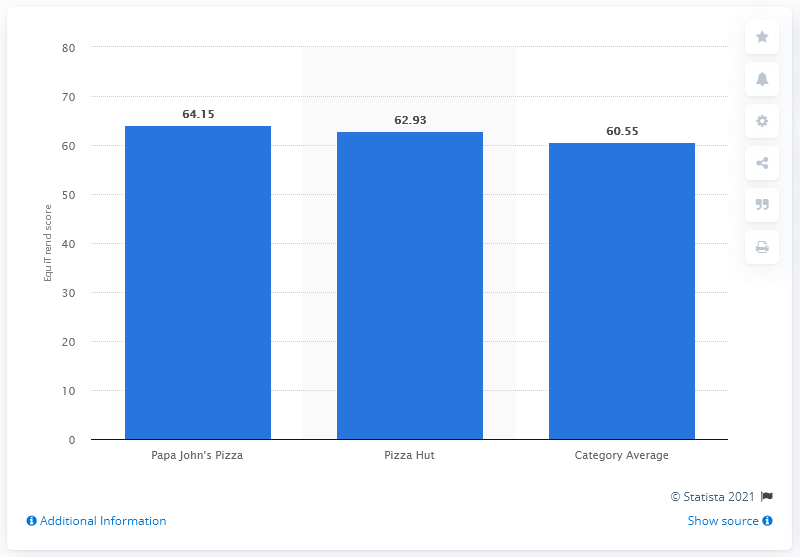

2. Title: Market value of delivered food and pizza delivery in the United Kingdom (UK) as of 2017*                                                     (in billion GBP) 
 Content: This statistic displays the total value of the pizza delivery market in the United Kingdom (UK) as of the end of 2017. The UK pizza delivery was reported to be worth 2.1 billion British pounds; This accounted for around a third of the total UK delivered food market, which was valued at 6.2 billion British pounds. 
 Score: 27.646492


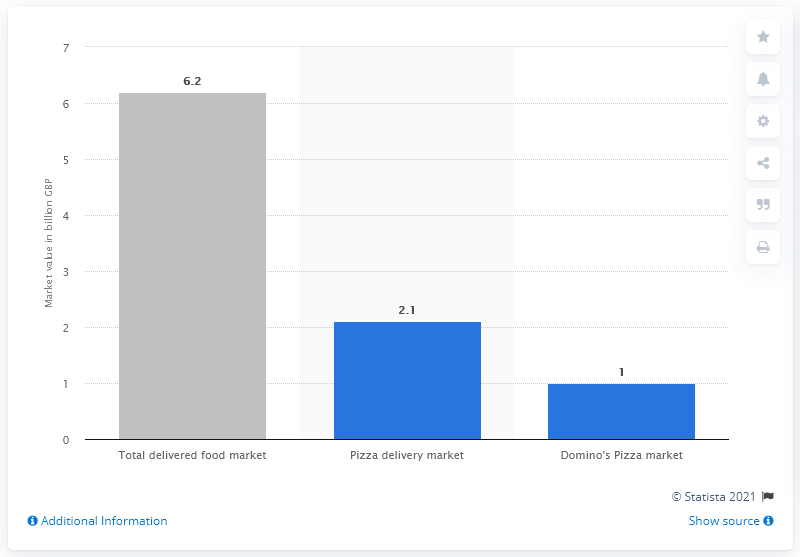

3. Title: Best-performing restaurant stocks in the United States in 2014* 
 Content: This statistic shows the best-performing restaurant stocks in the United States in 2014. BJ's Restaurant Inc. was the best-performing restaurant company in 2014, with a share price increase of 61.65 percent over the previous year. 
 Score: 27.508364


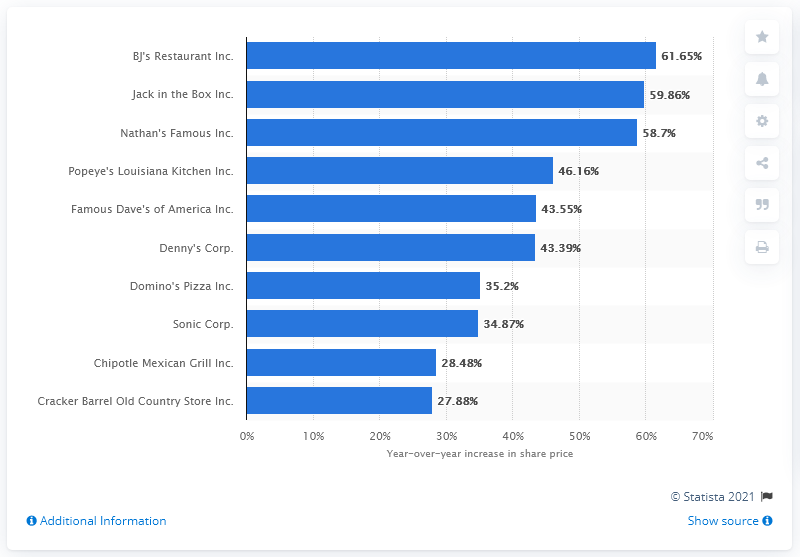

: 

In [10]:
# Text query example and fetching images based on text query
#inputs = processor(text=[text_query], padding=True, return_tensors="pt").to(device)
inputs = tokenizer(text=[text_query], padding=True, return_tensors="pt").to(device)

with torch.no_grad():
    text_features = model.get_text_features(**inputs).squeeze(0)
    text_features = (text_features / text_features.norm(p=2, dim=-1, keepdim=True)).cpu().numpy().tolist() # Move back to CPU for Elasticsearch

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'image_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": text_features,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()

## **Optional Code - Testing using the text and image embeddings together**

1. Indexing Combined Image and Text Embeddings
    - Generates a combined image-text embedding by concatenating both feature vectors and normalizing them before saving to Elasticsearch under `"imgtext_embedding"`.

2. Retrieving Images Using Random Image & Manual Text Query
    - Selects a random image, generates an embedding along with a manual text query, and retrieves the most relevant documents from Elasticsearch.

3. Displaying Retrieved Results
    - Fetches and decodes the top-matching images and their associated metadata, displaying them for verification.

In [28]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io

# Load data
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title', 'caption', 'imgPath']

pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
#sample_df = combined_df.head(100)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity

# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "documents"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 768}
            }
        }
    })
# The document already exist, with the new field name 'clip_embedding'

# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")

# Function to generate, combined, normalize image and text embedding
def generate_embedding(image, text):
    #image = image.convert("RGB")  # Ensure image is in RGB
    img_inputs = processor(images=[image], return_tensors="pt").to(device)
    txt_inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**img_inputs).squeeze(0)
        text_features = model.get_text_features(**txt_inputs).squeeze(0)
        combined_features = torch.cat([image_features, text_features], dim=-1)
        normalized_features = (combined_features / combined_features.norm(p=2, dim=-1, keepdim=True))
        return normalized_features.cpu().numpy().tolist()  # Move back to CPU for Elasticsearch indexing

# Indexing only images
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Combine title and caption to form a text used for embedding and hashing
    combined_text = f"{row['title']}. {row['caption']}"
    
    image_path = row['imgPath']
    image = Image.open(image_path)
    imgtext_emb = generate_embedding(image,combined_text)
    
    #combined_hash = row['title'] + row['caption']
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Update the document in Elasticsearch with the new clip_embedding
    es.update(index=index_name, id=unique_id, body={
        "doc": {
            "imgtext_embedding": imgtext_emb
        }
    })

Using device: cuda


100%|██████████| 29354/29354 [45:43<00:00, 10.70it/s] 


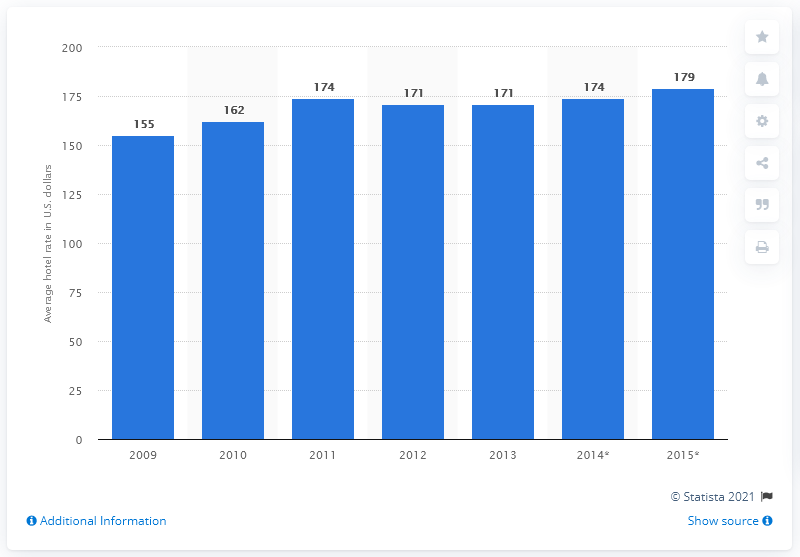

In [3]:
# Select a random row from the DataFrame
random_row = combined_df.sample(n=1).iloc[0]
# Retrieve the image path from the selected row
rand_image_path = random_row['imgPath']
rand_image = Image.open(rand_image_path)
rand_image.show()

Top 3 relevant documents based on text query:
1. Title: 
                        Average global hotel rates from 2009 to 2015 
                    
                            (in U.S. dollars)
                         
 Content:  This statistic shows average global hotel rates from 2009 to 2015. In 2013, the average global hotel rate was 171 U.S. dollars. This figure was forecasted to increase to 174 U.S. dollars in 2014 and again to 179 dollars in 2015.  
 Score: 89.66555


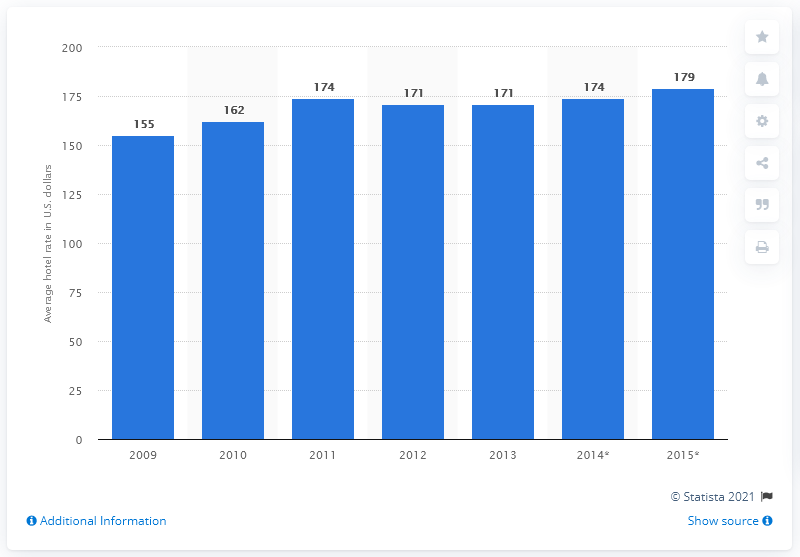

2. Title: 
                        Average travel spend per trip in the United States from 2012 to 2016 (in U.S. dollars)*
                     
 Content:  This statistic shows the average travel spend per trip in the United States from 2012 to 2016. In the 12 months leading up to May 2014, U.S. travelers spent an average of 1,364 U.S. dollars per trip.  
 Score: 87.07007


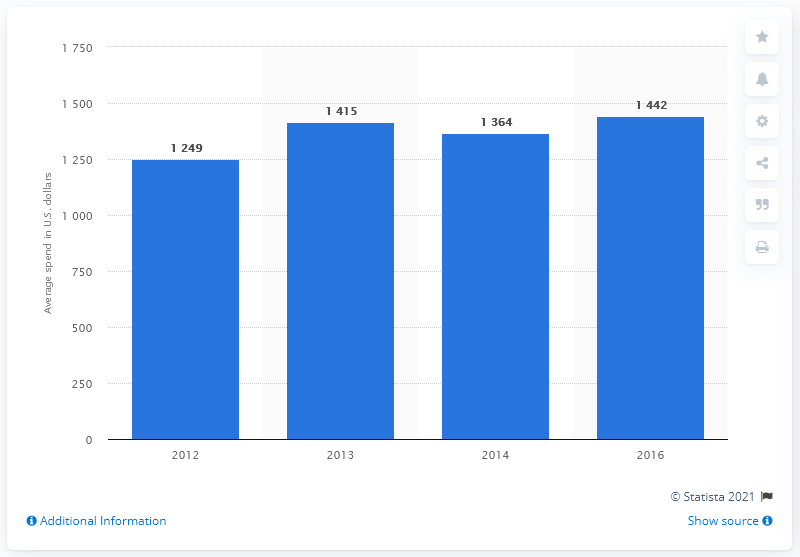

3. Title: 
                        Average room price in hotel transactions in the United Kingdom (UK) from 2009 to 2014 
                    
                            (in GBP)
                         
 Content:  This statistic presents the average price per room in hotel transactions in the United Kingdom (UK) between 2009 and 2014. In 2014 the average price per room in hotel transactions was 169,085 British pounds, which continues the trend of lower prices of the previous year and stands in contrast to the peak of 319,316 British pounds in 2010.  
 Score: 86.386024


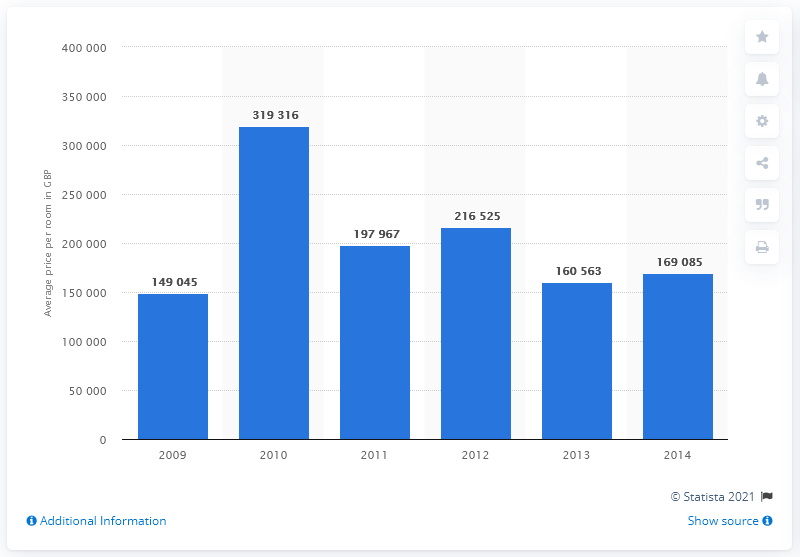

In [4]:
# Text query example and fetching images based on text query
text_query = "What are price of hotel rooms in the United States?"
query_emb = generate_embedding(rand_image,text_query)

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'imgtext_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": query_emb,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()